In [1]:
# !pip install "cloudpathlib[azure]" loguru tqdm typer
# !pip install xarray xarray-spatial

In [1]:
%reload_ext autoreload
%autoreload 2

# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
pd.set_option("display.max_colwidth", 250)
import matplotlib.pyplot as plt
import rasterio
import glob
import numpy as np
import pyproj
import xarray
import xrspatial.multispectral as ms
from PIL import Image

from src.train import train
from src.hyperparams import HyperParams, open_from_yaml
from src.dataloader import *
from src.datasets import LoadTifDataset

# Explore

In [2]:
train_meta = pd.read_csv("data/train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [3]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [4]:
train_meta["location"].value_counts()

Chifunfu      341
Timbuktu      321
Chingola      321
Lusaka        309
Bambesa       267
             ... 
Sudan           9
Gabon           9
Sfax            6
Morocco         4
Angkor Wat      2
Name: location, Length: 81, dtype: int64

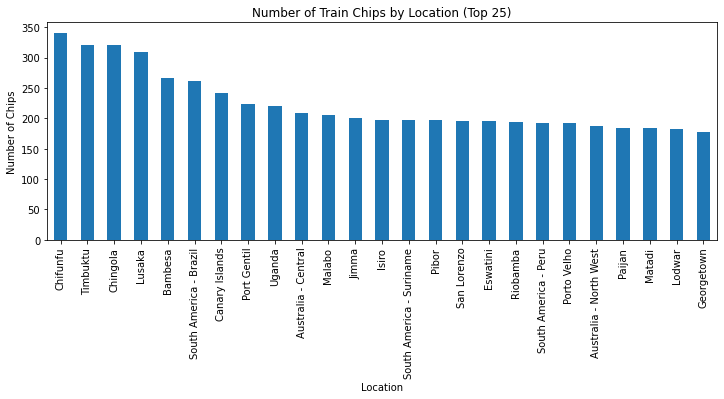

In [5]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)
plt.figure(figsize=(12, 4))
train_location_counts.head(25).plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Train Chips by Location (Top 25)")
plt.show()

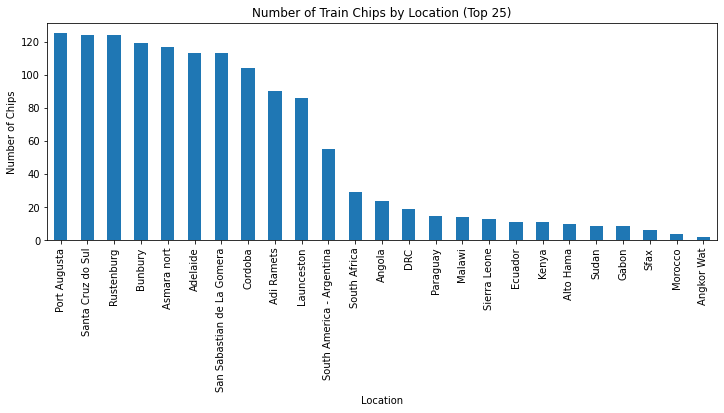

In [6]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)
plt.figure(figsize=(12, 4))
train_location_counts.tail(25).plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Train Chips by Location (Top 25)")
plt.show()

In [7]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

,chip_count
year,
2018,326
2019,1015
2020,10407


In [8]:
train_meta["datetime"].min(), train_meta["datetime"].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [9]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


In [10]:
BANDS = ["B02", "B03", "B04", "B08"]

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = df["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}.tif")
#         assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = df["chip_id"].apply(lambda x: f"{label_dir}/{x}.tif")
#         assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, "data/train_features", "data/train_labels")
train_meta.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,data/train_features/adwu/B02.tif,data/train_features/adwu/B03.tif,data/train_features/adwu/B04.tif,data/train_features/adwu/B08.tif,data/train_labels/adwu.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,data/train_features/adwz/B02.tif,data/train_features/adwz/B03.tif,data/train_features/adwz/B04.tif,data/train_features/adwz/B08.tif,data/train_labels/adwz.tif
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,data/train_features/adxp/B02.tif,data/train_features/adxp/B03.tif,data/train_features/adxp/B04.tif,data/train_features/adxp/B08.tif,data/train_labels/adxp.tif
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,data/train_features/aeaj/B02.tif,data/train_features/aeaj/B03.tif,data/train_features/aeaj/B04.tif,data/train_features/aeaj/B08.tif,data/train_labels/aeaj.tif


In [11]:
len(glob.glob("data/train_features/*")), len(glob.glob("data/train_features/*/*"))

(11747, 46982)

In [12]:
len(glob.glob("data/train_labels/*"))

11748

In [13]:
example_chip = train_meta.sample(1)

In [14]:
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32722),
 'transform': Affine(10.0, 0.0, 222295.0,
        0.0, -10.0, 6379455.0)}

In [15]:
# what does the image array look like?
print("Image array shape:", img_array.shape)
img_array

Image array shape: (512, 512)


array([[ 339,  338,  379, ..., 4276, 4200, 4164],
       [ 363,  332,  361, ..., 4392, 4392, 4388],
       [ 379,  349,  345, ..., 4652, 4700, 4560],
       ...,
       [ 466,  473,  509, ...,  819,  859,  826],
       [ 569,  610,  621, ..., 1298, 1456, 1460],
       [ 675,  817,  824, ..., 1670, 1968, 2058]], dtype=uint16)

In [16]:
np.isnan(img_array).sum()

0

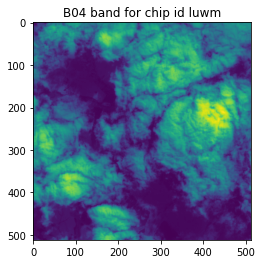

In [17]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

In [18]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: -53.93531987419144, latitude: -32.711406538456856


In [19]:
bounds

BoundingBox(left=222295.0, bottom=6374335.0, right=227415.0, top=6379455.0)

In [20]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (-32.73510599475863, -53.963362610976155)
End: (-32.687702183718244, -53.907291138827375)


In [21]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir="data/train_features"):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = f"{data_dir}/{chip_id}"
    red = get_xarray(f"{chip_dir}/B04.tif")
    green = get_xarray(f"{chip_dir}/B03.tif")
    blue = get_xarray(f"{chip_dir}/B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

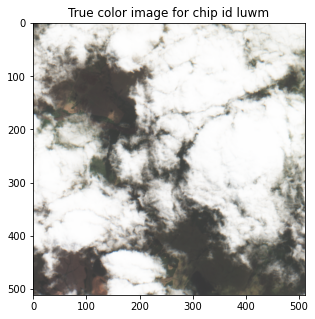

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")
plt.show()

In [23]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = np.array(Image.open(random_chip.label_path))
    ax[1].imshow(label_im, cmap="gray")
    ax[1].set_title(f"Chip {random_chip.chip_id} label, {100 * (label_im.sum()/512**2):.1f}% clouds")

    plt.tight_layout()
    plt.show()

In [25]:
# for k in range(100):
#     display_random_chip(k)

In [26]:
train_meta = pd.read_csv("data/train_metadata.csv")
bands = ["B02", "B03", "B04", "B08"]
feature_dir = "data/train_features"
label_dir = "data/train_labels"

for band in bands:
    train_meta[f"{band}_path"] = train_meta["chip_id"].apply(lambda x: f"{feature_dir}/{x}/{band}.tif")
if label_dir is not None:
    train_meta["label_path"] = train_meta["chip_id"].apply(lambda x: f"{label_dir}/{x}.tif")

In [29]:
folds = [0, 1, 2, 3, 4] * (len(train_meta) // 5 + 1)
folds = folds[:len(train_meta)]

seed = 1335
np.random.seed(seed)
np.random.shuffle(folds)

In [30]:
train_meta["fold"] = folds
train_meta.sample(5)

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path,fold
1071,bxxh,Adelaide,2020-09-11T00:56:48Z,az://./train_features/bxxh,data/train_features/bxxh/B02.tif,data/train_features/bxxh/B03.tif,data/train_features/bxxh/B04.tif,data/train_features/bxxh/B08.tif,data/train_labels/bxxh.tif,1
1593,crqn,Chingola,2020-05-07T08:33:36Z,az://./train_features/crqn,data/train_features/crqn/B02.tif,data/train_features/crqn/B03.tif,data/train_features/crqn/B04.tif,data/train_features/crqn/B08.tif,data/train_labels/crqn.tif,4
85,agka,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/agka,data/train_features/agka/B02.tif,data/train_features/agka/B03.tif,data/train_features/agka/B04.tif,data/train_features/agka/B08.tif,data/train_labels/agka.tif,3
535,asxk,Chingola,2020-07-26T08:33:40Z,az://./train_features/asxk,data/train_features/asxk/B02.tif,data/train_features/asxk/B03.tif,data/train_features/asxk/B04.tif,data/train_features/asxk/B08.tif,data/train_labels/asxk.tif,3
10836,ydjb,Australia - Central,2020-08-11T01:24:00Z,az://./train_features/ydjb,data/train_features/ydjb/B02.tif,data/train_features/ydjb/B03.tif,data/train_features/ydjb/B04.tif,data/train_features/ydjb/B08.tif,data/train_labels/ydjb.tif,4


In [31]:
train_meta["path_exists"] = train_meta["B02_path"].apply(lambda x: os.path.exists(x))
train_meta.shape

(11748, 11)

In [32]:
train_meta = train_meta[train_meta["path_exists"]==True]
train_meta.shape

(11745, 11)

In [33]:
train_meta.to_pickle("data/trainval_2021_12_20.pkl")

# Train

In [37]:
# import shutil
# shutil.rmtree("trained_models/Exp0/")

In [ ]:
exp_nb = "0"
path = 'data/trainval_2021_12_20.pkl'

hps_dict = {
    ############
    # Data
    ############
    "df_path": path,

    ############
    # Training
    ############

    ## Experiment Setup
    "name": f"Exp{exp_nb}",

    ## Model
    "num_classes": 1,
    "input_channel": 4,
    "backbone": "timm_efficientnet_b1",
    "pretrained": 1,

    # Training Setup
    "print_freq": 1000,
    "use_fp16": 1,
    "patience": 4,

    # Optimizer
    "lr": 0.001,
    "weight_decay": 0.0,

    ## Data Augmentation on CPU
    "train_crop_size": 384,

    # Data Augmentation on GPU
    "gpu_da_params": [0.25],
           }

for fold_nb in range(5):
    hps = HyperParams(**hps_dict)
    hps.fold_nb = fold_nb
    num_batches = 8000 // (32 * torch.cuda.device_count())
    hps.num_batches = num_batches
    train_dataset, train_loader, val_dataset, val_loader = get_dataloaders(hps)
#     continue

    best_metric, best_metric_epoch = train(hps, train_loader, val_loader)

20-Dec-21 22:21:47 - Training with 1 GPUS


Train Data Augmentations: [RandomCrop(always_apply=False, p=1.0, height=384, width=384)]
####################################################################################################
####################################################################################################
Fold 0 --> Train: 9395, Val: 2350
####################################################################################################
timm-efficientnet-b1 noisy-student BatchNorm: True Decoder Channel: [256, 128, 64, 32, 16], Decoder Attention Type: None


20-Dec-21 22:21:48 - Training is done with mixed precision
20-Dec-21 22:23:02 - Ep: [1] TotalT: 1.2 min, BatchT: 0.294s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.1980
20-Dec-21 22:23:15 - Ep: [1]  ValT: 0.22 min, BatchT: 0.176s, DataT: 0.015s, Loss: 0.1683, IoU: 0.8781 (val)
20-Dec-21 22:24:25 - Ep: [2] TotalT: 2.6 min, BatchT: 0.276s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.1711
20-Dec-21 22:24:35 - Ep: [2]  ValT: 0.17 min, BatchT: 0.136s, DataT: 0.017s, Loss: 0.1757, IoU: 0.8646 (val)
20-Dec-21 22:25:42 - Ep: [3] TotalT: 3.9 min, BatchT: 0.267s, DataT: 0.003s, GpuDaT: 0.002s, Loss: 0.1651
20-Dec-21 22:25:52 - Ep: [3]  ValT: 0.16 min, BatchT: 0.129s, DataT: 0.011s, Loss: 0.1615, IoU: 0.8809 (val)
20-Dec-21 22:26:59 - Ep: [4] TotalT: 5.2 min, BatchT: 0.267s, DataT: 0.004s, GpuDaT: 0.002s, Loss: 0.1577
20-Dec-21 22:27:09 - Ep: [4]  ValT: 0.16 min, BatchT: 0.130s, DataT: 0.012s, Loss: 0.1564, IoU: 0.8887 (val)
20-Dec-21 22:28:17 - Ep: [5] TotalT: 6.5 min, BatchT: 0.272s, DataT: 0.003s, GpuD

In [ ]:
# for k in range(20):
#     try:
#         train_dataset.visualize()
#     except:
#         pass

In [ ]:
# for k in range(10):
#     val_dataset.visualize()

# Validate

# Submit

In [ ]:
submission_dir = Path("benchmark_src")
shutil.copyfile(, submission_dir / "assets/cloud_model.pt")

In [35]:
%%file benchmark_src/main.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer

try:
    from src.datasets import LoadTifDataset
    from src.model import build_model
except ImportError:
    from benchmark_src.datasets import LoadTifDataset
    from benchmark_src.model import build_model

ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")


def get_metadata(features_dir, bands):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [f"{features_dir}/{chip_id}/{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(model, x_paths, bands, predictions_dir):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    test_dataset = LoadTifDataset(img_paths=x_paths, mask_paths=None, test=True)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        pin_memory=True,
    )

    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["chip"]
        preds = model.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5).detach().numpy().astype("uint8")
        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    model_weights_path: Path = ASSETS_DIRECTORY / "cloud_model.pt",
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04", "B08"],
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in test_features_dir using the model saved at
    model_weights_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        test_features_dir (os.PathLike, optional): Path to the features for the test data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not os.path.exists(test_features_dir):
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    os.makedirs(predictions_dir, exist_ok=True)

    logger.info("Loading model")
    model = CloudModel(bands=bands, hparams={"weights": None})
    model.load_state_dict(torch.load(model_weights_path))

    logger.info("Loading test metadata")
    test_metadata = get_metadata(test_features_dir, bands=bands)
    if fast_dev_run:
        test_metadata = test_metadata.head()
    logger.info(f"Found {len(test_metadata)} chips")

    logger.info("Generating predictions in batches")
    make_predictions(model, test_metadata, bands, predictions_dir)

    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    typer.run(main)

Writing benchmark_src/main.py


In [ ]:
from benchmark_src.main import main

main(
    model_weights_path=submission_dir / "assets/cloud_model.pt",
    test_features_dir=DATA_DIR / "test_features",
    predictions_dir=submission_dir / 'predictions',
    fast_dev_run=True,
)